# データローダーのテスト

自己教師あり学習用にデータローダーをいじくることにする．


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets


In [17]:

class SelfSupervisedDataset(Dataset):
    def __init__(self, base_dataset, transform_1, transform_2):
        """
        Args:
            base_dataset (Dataset): 元となるデータセット（例: CIFAR-10）。
            transform_1 (callable): 1つ目のデータ拡張。
            transform_2 (callable): 2つ目のデータ拡張。
        """
        self.base_dataset = base_dataset
        self.transform_1 = transform_1
        self.transform_2 = transform_2

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]  # 元画像とラベルを取得

        # base が PIL 形式であることを仮定
        # なので，ToTensor で先にいじるとしくじる

        augmented_1 = self.transform_1(img)  # データ拡張1を適用
        augmented_2 = self.transform_2(img)  # データ拡張2を適用
        return augmented_1, augmented_2, label

# オリジナルを取り出す場合
transform_original = transforms.Compose([
    transforms.ToTensor(),
])

# 1つ目のデータ拡張
transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(size=96),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# 2つ目のデータ拡張
transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(size=96),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

# CIFAR-10データセットのロード（augumentation で transform するので変換はしない）
# base_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=None)

# STL-10データセットのロード（augumentation で transform するので変換はしない）
base_dataset = datasets.STL10(root="./data", download=True, transform=None)

# カスタムデータセットを作成
# 最初の方はオリジナル，後者は transform_1 でデータ拡張
self_supervised_dataset = SelfSupervisedDataset(base_dataset, transform_original, transform_1)

# 最初の方は transform_1，後者は transform_1 でデータ拡張
# self_supervised_dataset = SelfSupervisedDataset(base_dataset, transform_1, transform_2)

# DataLoaderを作成
dataloader = DataLoader(self_supervised_dataset, batch_size=64, shuffle=True, num_workers=4)


Files already downloaded and verified


Augmented 1 shape: torch.Size([64, 3, 96, 96]), Augmented 2 shape: torch.Size([64, 3, 96, 96])


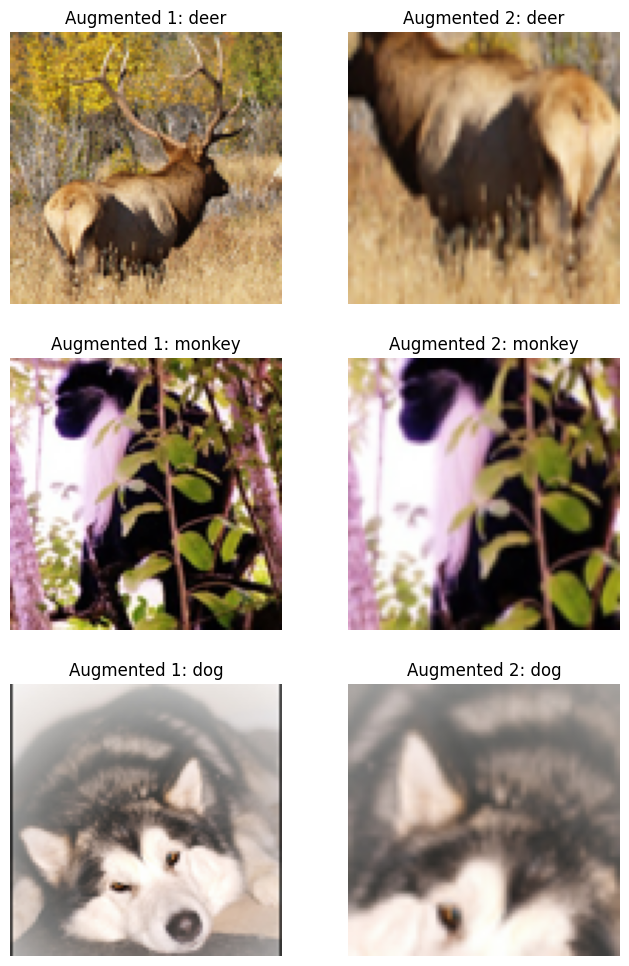

In [18]:
import matplotlib.pyplot as plt

cifar10_labels_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
stl10_labels_map = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
labels_map = stl10_labels_map

# データの確認

# サンプルループ（1バッチ分のデータを取得）
for batch in dataloader:
    augmented_1, augmented_2, labels = batch
    print(f"Augmented 1 shape: {augmented_1.shape}, Augmented 2 shape: {augmented_2.shape}")
    break

#next(iter(dataloader)) # num_workers と，next(iter(dataloader)) の組み合わせはデッドロックを生じさせる可能性あり
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
for i in range(3):
    ax[i, 0].imshow(augmented_1[i].permute(1, 2, 0))
    ax[i, 1].imshow(augmented_2[i].permute(1, 2, 0))
    ax[i, 0].set_title(f"Augmented 1: {labels_map[labels[i].item()]}")
    ax[i, 1].set_title(f"Augmented 2: {labels_map[labels[i].item()]}")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
